In [105]:
# Basic data manipulation
import pandas as pd
import numpy as np

# For progress bars (makes waiting easier!)
from tqdm import tqdm

# For data visualization
import matplotlib.pyplot as plt

import seaborn as sns

# For machine learning
import xgboost as xgb
from sklearn.model_selection import train_test_split

# For evaluation metrics
from sklearn.metrics import ndcg_score

# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


 ## Load Our Data

In [106]:
# Load the data
comps_df = pd.read_csv('../data/model_ready/comp_pair_model_ready.csv')
candidates_df = pd.read_csv('../data/model_ready/candidates_pair_model_ready.csv')

print(f"📊 Data loaded successfully!")
print(f"   - Comps: {len(comps_df):,} rows")
print(f"   - Candidates: {len(candidates_df):,} rows")

📊 Data loaded successfully!
   - Comps: 264 rows
   - Candidates: 9,820 rows


## Quick Data Exploration

In [107]:
# Check how many unique subjects we have
n_subjects = comps_df['orderID'].nunique()
print(f"\n🏠 Number of subjects: {n_subjects}")

# Check comps per subject (should be 3)
comps_per_subject = comps_df.groupby('orderID').size()
print(f"\n📌 Comps per subject:")
print(f"   - Min: {comps_per_subject.min()}")
print(f"   - Max: {comps_per_subject.max()}")
print(f"   - Average: {comps_per_subject.mean():.1f}")

# Check candidates per subject (varies)
candidates_per_subject = candidates_df.groupby('orderID').size()
print(f"\n📋 Candidates per subject:")
print(f"   - Min: {candidates_per_subject.min()}")
print(f"   - Max: {candidates_per_subject.max()}")
print(f"   - Average: {candidates_per_subject.mean():.1f}")


🏠 Number of subjects: 88

📌 Comps per subject:
   - Min: 3
   - Max: 3
   - Average: 3.0

📋 Candidates per subject:
   - Min: 3
   - Max: 735
   - Average: 111.6


##  Add Labels

In [108]:
# Add labels
comps_df['label'] = 1
candidates_df['label'] = 0

# Combine the dataframes
combined_df = pd.concat([comps_df, candidates_df], ignore_index=True)

print(f"\n✅ Data combined!")
print(f"   Total rows: {len(combined_df):,}")
print(f"   - Positive (comps): {(combined_df['label'] == 1).sum():,}")
print(f"   - Negative (candidates): {(combined_df['label'] == 0).sum():,}")


✅ Data combined!
   Total rows: 10,084
   - Positive (comps): 264
   - Negative (candidates): 9,820


In [109]:
# Count properties per orderID
properties_per_order = combined_df.groupby('orderID').size()
print(f"\n📊 Properties per subject:")
print(f"   - Min: {properties_per_order.min()}")
print(f"   - Max: {properties_per_order.max()}")
print(f"   - Average: {properties_per_order.mean():.1f}")


📊 Properties per subject:
   - Min: 6
   - Max: 738
   - Average: 114.6


In [110]:
# Save the combined dataset
combined_df.to_csv('../data/model_ready/combined_ranking_data.csv', index=False)
print(f"\n💾 Saved to: '../data/model_ready/combined_ranking_data.csv'")


💾 Saved to: '../data/model_ready/combined_ranking_data.csv'


## STEP 2

In [111]:
# Sort by orderID to keep all properties of same subject together
combined_df = combined_df.sort_values('orderID').reset_index(drop=True)
print("✅ Data sorted by orderID")

✅ Data sorted by orderID


In [112]:
# Count how many properties each orderID has
group_sizes = combined_df.groupby('orderID').size().values

print(f"\n📊 Group structure created!")
print(f"   - Number of groups (subjects): {len(group_sizes)}")
print(f"   - Total properties: {group_sizes.sum()}")
print(f"   - Example first 5 groups: {group_sizes[:5]}")


📊 Group structure created!
   - Number of groups (subjects): 88
   - Total properties: 10084
   - Example first 5 groups: [ 36 177 144 168 540]


In [113]:
combined_df.columns

Index(['orderID', 'subj_gla', 'gla_clean', 'gla_diff', 'subj_lot_size',
       'lot_size_clean', 'lot_size_diff', 'subj_bedrooms', 'bedrooms_clean',
       'bedroom_diff', 'subj_bathrooms', 'bathrooms_clean', 'bathroom_diff',
       'subj_room_count', 'room_count_clean', 'room_count_diff',
       'subj_property_type', 'property_type_clean', 'same_property_type',
       'subj_stories', 'stories_clean', 'same_storey_type', 'sale_date_clean',
       'sold_recently_90', 'sold_recently_180', 'label', 'close_date_clean',
       'id'],
      dtype='object')

In [114]:
# Select feature columns (everything except orderID and label)
feature_columns = [
    'gla_diff', 
    'lot_size_diff',
    'bedroom_diff',
    'bathroom_diff',
    'room_count_diff',
    'same_property_type',
    'same_storey_type',
    'sold_recently_90',
]


# Get features and labels
X = combined_df[feature_columns]
y = combined_df['label']

print(f"\n✅ Features and labels ready!")
print(f"   - Number of features: {len(feature_columns)}")
print(f"   - Feature shape: {X.shape}")
print(f"   - Labels shape: {y.shape}")


✅ Features and labels ready!
   - Number of features: 8
   - Feature shape: (10084, 8)
   - Labels shape: (10084,)


In [115]:
# We need to split by complete groups (orderIDs), not randomly
unique_orderIDs = combined_df['orderID'].unique()

np.random.seed(42)
unique_orderIDs = np.random.permutation(unique_orderIDs) 

n_train_groups = int(0.8 * len(unique_orderIDs))  # 80% for training

# Split orderIDs
train_orderIDs = unique_orderIDs[:n_train_groups]
test_orderIDs = unique_orderIDs[n_train_groups:]

# Create train/test sets
train_mask = combined_df['orderID'].isin(train_orderIDs)
test_mask = combined_df['orderID'].isin(test_orderIDs)

X_train = X[train_mask]
X_test = X[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

# Get group sizes for train and test
train_groups = combined_df[train_mask].groupby('orderID').size().values
test_groups = combined_df[test_mask].groupby('orderID').size().values

print(f"\n✅ Train/Test split complete!")
print(f"   Training:")
print(f"   - Groups: {len(train_groups)}")
print(f"   - Properties: {len(X_train)}")
print(f"   Testing:")
print(f"   - Groups: {len(test_groups)}")
print(f"   - Properties: {len(X_test)}")


✅ Train/Test split complete!
   Training:
   - Groups: 70
   - Properties: 8315
   Testing:
   - Groups: 18
   - Properties: 1769


## 🚀 Step 3: Train an XGBoost Ranking Model (Pairwise)

We’ll:
- Create DMatrix objects for XGBoost
- Set up ranking parameters
- Train the model
- (Optionally) Evaluate how well it does on the test set

> **NOTE:**  
> We’ll use `rank:pairwise` objective, which tells XGBoost to learn to rank comps higher within each group.


In [116]:
# 1️⃣ Create DMatrix objects for XGBoost (with features and labels)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# 2️⃣ Set group information (list of group sizes)
dtrain.set_group(train_groups)
dtest.set_group(test_groups)


In [117]:
# 3️⃣ Set XGBoost parameters for pairwise ranking
params = {
    'objective': 'rank:pairwise',
    'eval_metric': 'ndcg@3',  # NDCG@3 is good for Top-3 recommendations!
    'eta': 0.1,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}


In [118]:
# 4️⃣ Train the model!
evals = [(dtrain, 'train'), (dtest, 'test')]

model = xgb.train(
    params,
    dtrain,
    num_boost_round=100,
    evals=evals,
    early_stopping_rounds=10,
    verbose_eval=10
)


[0]	train-ndcg@3:0.56808	test-ndcg@3:0.43482
[10]	train-ndcg@3:0.84270	test-ndcg@3:0.66946
[13]	train-ndcg@3:0.87478	test-ndcg@3:0.64060


## CHECKING ACCURACY

In [119]:
import numpy as np
import pandas as pd

# 1. Get model predictions on the test set
test_preds = model.predict(dtest)

# 2. Attach predictions and original labels to the test DataFrame
test_df = X_test.copy()
test_df['orderID'] = combined_df[test_mask]['orderID'].values
test_df['label'] = y_test.values
test_df['pred'] = test_preds

# 3. For each group, rank candidates by prediction
top_k = 3
hit_count = 0
total_groups = 0

for order_id, group in test_df.groupby('orderID'):
    # Sort candidates by prediction (descending)
    group_sorted = group.sort_values('pred', ascending=False)
    # Check if any of the top_k have label == 1 (true comp)
    top_k_labels = group_sorted.head(top_k)['label'].values
    if 1 in top_k_labels:
        hit_count += 1
    total_groups += 1

hit_rate = hit_count / total_groups

print(f"\n🎯 Top-{top_k} Hit Rate: {hit_rate:.2%} ({hit_count}/{total_groups})")



🎯 Top-3 Hit Rate: 94.44% (17/18)


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1715
           1       0.63      0.63      0.63        54

    accuracy                           0.98      1769
   macro avg       0.81      0.81      0.81      1769
weighted avg       0.98      0.98      0.98      1769



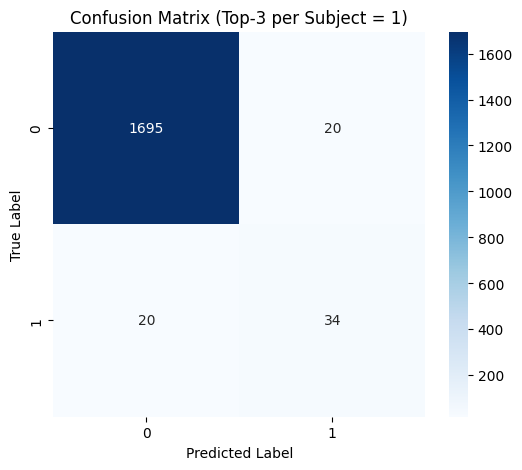


ROC AUC Score: 0.926


In [120]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Attach preds and orderID to test_df (already done earlier)
test_df['pred'] = test_preds

# For each group, assign label 1 to top 3 predicted, else 0
test_df['pred_label'] = 0

for order_id, group in test_df.groupby('orderID'):
    # Top 3 indices by prediction
    top3_idx = group['pred'].nlargest(3).index
    test_df.loc[top3_idx, 'pred_label'] = 1

# Now you have test_df['label'] (ground truth) and test_df['pred_label'] (model prediction)

# Classification report
print(classification_report(test_df['label'], test_df['pred_label']))

# Confusion matrix
cm = confusion_matrix(test_df['label'], test_df['pred_label'])
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Top-3 per Subject = 1)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ROC AUC (using raw prediction scores, not pred_label)
auc_score = roc_auc_score(test_df['label'], test_df['pred'])
print(f"\nROC AUC Score: {auc_score:.3f}")


## TOP 3

In [121]:
# --- 1. Define your features and output columns ---

# List of feature columns you used in your model (must match training!)
my_features = [
    'gla_diff', 'lot_size_diff', 'bedroom_diff', 'bathroom_diff', 'room_count_diff',
    'same_property_type', 'same_storey_type', 'sold_recently_90'
    # Add/remove your actual model features here!
]

# Columns you want in the final output
output_columns = [
    'orderID',           # Subject/order id
    'id',                # Unique property id for candidate
    # --- gla --- #
    'subj_gla', 'gla_clean',  'gla_diff',
    # --- lotsize ---#
    'subj_lot_size', 'lot_size_clean', 'lot_size_diff',
    # --- property type --- #
    'subj_property_type', 'property_type_clean', 'same_property_type',
    # --- storey type --- #
    'subj_stories', 'stories_clean', 'same_storey_type',
    # --- room --- #
    'subj_room_count', 'room_count_clean', 'room_count_diff',
    # --- bedroom --- #
    'subj_bedrooms', 'bedrooms_clean', 'bedroom_diff',
    # --- bathroom --- #
    'subj_bathrooms', 'bathrooms_clean', 'bathroom_diff',
    # --- sold --- #
    'sold_recently_90', 'sold_recently_180',
    # --- Model ---
    'pred'
    # --- Ranking (added below) ---
]

# --- 2. Filter to candidates only ---
candidates_only = combined_df[combined_df['label'] == 0].copy()

# --- 3. Predict scores for all candidates ---
candidates_only['pred'] = model.predict(xgb.DMatrix(candidates_only[my_features]))

# --- 4. Get top-3 recommended candidates for each subject ---
top_k = 3
top3_results = []

for order_id, group in candidates_only.groupby('orderID'):
    group_sorted = group.sort_values('pred', ascending=False)
    group_sorted = group_sorted.head(top_k).copy()
    group_sorted['rank'] = range(1, len(group_sorted) + 1)   # 1, 2, 3
    top3_results.append(group_sorted)

top3_candidates_df = pd.concat(top3_results).reset_index(drop=True)

# --- 5. Only keep the desired columns (including rank) ---
output_columns_final = output_columns + ['rank']
top3_candidates_df = top3_candidates_df[output_columns_final]

# --- 6. Save to CSV and preview ---
top3_candidates_df.to_csv('../data/results/top3_candidates_recommendations.csv', index=False)
display(top3_candidates_df.head(10))
print("✅ Top 3 candidate comps per subject saved to 'top3_candidates_recommendations.csv'")


,orderID,id,subj_gla,gla_clean,gla_diff,subj_lot_size,lot_size_clean,lot_size_diff,subj_property_type,property_type_clean,...,subj_bedrooms,bedrooms_clean,bedroom_diff,subj_bathrooms,bathrooms_clean,bathroom_diff,sold_recently_90,sold_recently_180,pred,rank
0,4723364,77566.0,1254.000,1300.0,46.000,609840.000,3636.0,606204.000,Detached,Detached,...,3.0,3.0,0.0,1.5,2.0,0.5,1,1,0.202051,1
1,4723364,19364.0,1254.000,1697.0,443.000,609840.000,22200.0,587640.000,Detached,Detached,...,3.0,3.0,0.0,1.5,1.0,0.5,0,1,0.085297,2
2,4723364,16978.0,1254.000,1456.0,202.000,609840.000,3136.0,606704.000,Detached,Detached,...,3.0,3.0,0.0,1.5,2.5,1.0,0,1,0.028734,3
3,4742669,33996.0,839.592,839.0,0.592,4639.284,5392.0,752.716,Detached,Detached,...,2.0,3.0,1.0,2.0,2.0,0.0,1,1,0.722336,1
4,4742669,206055.0,839.592,693.0,146.592,4639.284,7825.0,3185.716,Detached,Detached,...,2.0,2.0,0.0,2.0,1.0,1.0,1,1,0.346653,2
5,4742669,34006.0,839.592,959.0,119.408,4639.284,6157.0,1517.716,Detached,Detached,...,2.0,3.0,1.0,2.0,2.0,0.0,1,1,0.009836,3
6,4752865,52723.0,2974.000,2219.0,755.000,6512.220,3912.7,2599.520,Detached,Detached,...,4.0,3.0,1.0,2.5,2.5,0.0,1,1,0.440703,1
7,4752865,286771.0,2974.000,2194.0,780.000,6512.220,4600.4,1911.820,Detached,Detached,...,4.0,3.0,1.0,2.5,2.5,0.0,1,1,0.295418,2
8,4752865,274153.0,2974.000,2002.0,972.000,6512.220,3340.1,3172.120,Detached,Detached,...,4.0,4.0,0.0,2.5,2.5,0.0,1,1,0.264337,3
9,4755196,76980.0,2956.000,2826.0,130.000,3601.000,3168.0,433.000,Detached,Detached,...,4.0,4.0,0.0,3.5,4.0,0.5,1,1,0.515453,1


✅ Top 3 candidate comps per subject saved to 'top3_candidates_recommendations.csv'


## Model 

In [122]:
model.save_model('../model/xgb_ranking_model.json')
print("Model saved as 'xgb_ranking_model.json'")

Model saved as 'xgb_ranking_model.json'


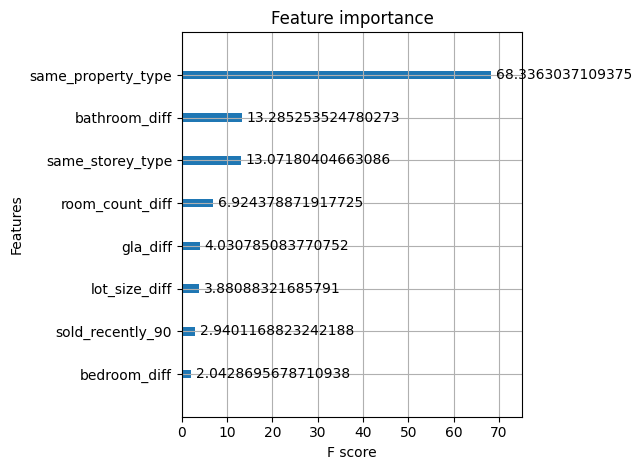

In [123]:
ax = xgb.plot_importance(model, max_num_features=10, importance_type='gain')
plt.tight_layout()  # (Optional: makes layout cleaner)
plt.savefig('../data/results/feature_importance.png', dpi=300)  # <-- Saves the plot as a PNG
plt.show()  # Display in notebook
